In [143]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

Spark Session Initialization

In [144]:
spark = SparkSession.builder.appName("HealthcareStroke").getOrCreate()
spark

Loading the dataset

In [145]:
file_path = "D:/Big data proposal/healthcare-dataset-stroke-data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

Explratory Data Analysis

In [146]:
# Display top 10 rows of the DataFrame
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [147]:
# The shape of the DataFrame
print((df.count(), len(df.columns)))

(5110, 12)


Missing Values

In [148]:
missing_cols = [col(c).alias(c + "_missing") for c in df.columns]
df.select(missing_cols).show()

+----------+--------------+-----------+--------------------+---------------------+--------------------+-----------------+----------------------+-------------------------+-----------+----------------------+--------------+
|id_missing|gender_missing|age_missing|hypertension_missing|heart_disease_missing|ever_married_missing|work_type_missing|Residence_type_missing|avg_glucose_level_missing|bmi_missing|smoking_status_missing|stroke_missing|
+----------+--------------+-----------+--------------------+---------------------+--------------------+-----------------+----------------------+-------------------------+-----------+----------------------+--------------+
|      9046|          Male|       67.0|                   0|                    1|                 Yes|          Private|                 Urban|                   228.69|       36.6|       formerly smoked|             1|
|     51676|        Female|       61.0|                   0|                    0|                 Yes|    Self-empl

The percentage of missing data in the "bmi" column of a DataFrame "df" is determined by this line of code. 

In [149]:
bmi_missing_percentage = (df.filter(col("bmi").isNull()).count() / df.count()) * 100
print(bmi_missing_percentage)

0.0


Visualization of missing values in the bmi column

In [150]:
bmi_missing_count = df.filter(col("bmi").isNull()).count()
bmi_not_missing_count = df.filter(col("bmi").isNotNull()).count()
bmi_data = [(bmi_missing_count, "Null"), (bmi_not_missing_count, "Not Null")]
bmi_df = spark.createDataFrame(bmi_data, ["count", "status"])
bmi_df = bmi_df.withColumn("status", col("status").cast("string"))
bmi_df.show()

+-----+--------+
|count|  status|
+-----+--------+
|    0|    Null|
| 5110|Not Null|
+-----+--------+



In [151]:
# Define a function to categorize columns
def col_names(df):
    cat_cols = [col for col, dtype in df.dtypes if dtype not in ["int", "double"]]
    num_cols = [col for col, dtype in df.dtypes if dtype in ["int", "double"]]
    num_but_cat = [col for col in num_cols if df.select(col).distinct().count() < 12]
    cat_cols = num_but_cat + cat_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    cat_but_car = [col for col in cat_cols if df.select(col).distinct().count() > 12]
    print(f"Numerical Cols: {num_cols} \nCategorical Cols: {cat_cols} \nNumerical but Categorical: {num_but_cat} \nCategorical but Cardinal: {cat_but_car}") 
    return num_cols, cat_cols

In [152]:
num_cols, cat_cols = col_names(df)

Numerical Cols: ['id', 'age', 'avg_glucose_level'] 
Categorical Cols: ['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'bmi', 'smoking_status'] 
Numerical but Categorical: ['hypertension', 'heart_disease', 'stroke'] 
Categorical but Cardinal: ['bmi']


In [153]:
# Displaying summary statistics for numerical columns
df.describe(num_cols).show()

+-------+-----------------+------------------+------------------+
|summary|               id|               age| avg_glucose_level|
+-------+-----------------+------------------+------------------+
|  count|             5110|              5110|              5110|
|   mean|36517.82935420744|43.226614481409015|106.14767710371804|
| stddev|21161.72162482715| 22.61264672311348| 45.28356015058193|
|    min|               67|              0.08|             55.12|
|    max|            72940|              82.0|            271.74|
+-------+-----------------+------------------+------------------+



Analyzing Numerical Variables

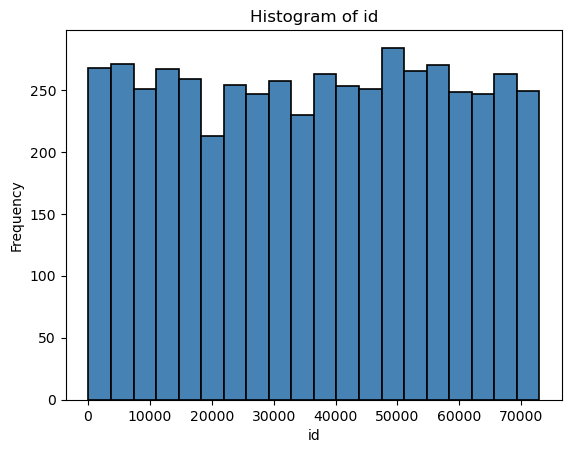

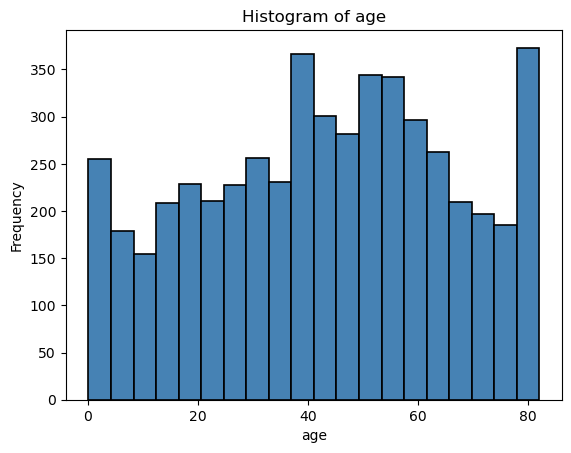

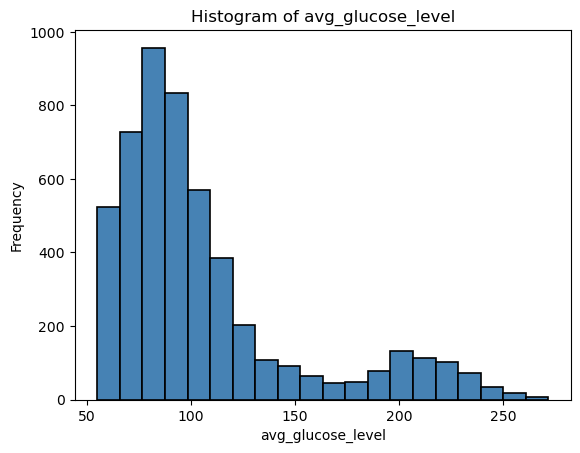

In [154]:
# Visualize histograms for numerical columns
for col_name in num_cols:
    plt.hist(df.select(col(col_name)).dropna().rdd.flatMap(lambda x: x).collect(),edgecolor='black', linewidth=1.2, bins=20, color="steelblue")
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show(block=True)

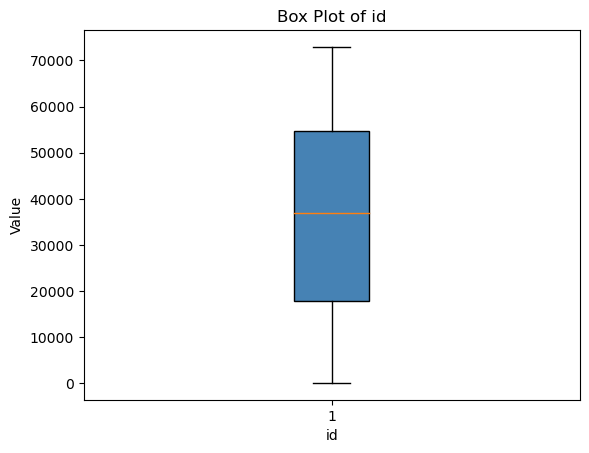

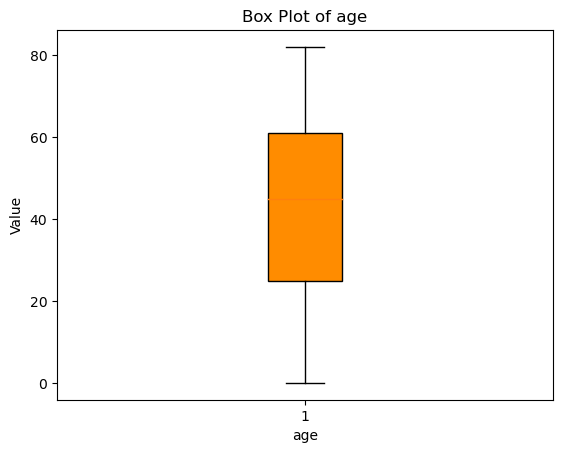

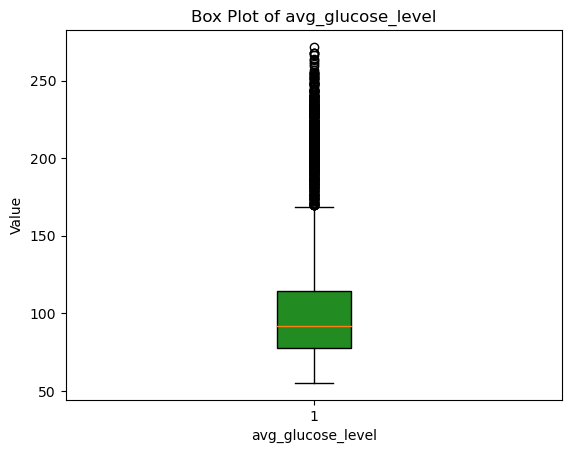

In [155]:
# Assuming 'num_cols' contains the list of numerical column names in your DataFrame
colors = ["steelblue", "darkorange", "forestgreen", "purple"]  # Add more colors as needed

for i, col_name in enumerate(num_cols):
    # Collect the numerical data for the current column
    data = df.select(col(col_name)).dropna().rdd.flatMap(lambda x: x).collect()
    
    # Create the box plot with a specified color
    plt.figure()
    plt.boxplot(data, patch_artist=True, boxprops=dict(facecolor=colors[i]))
    plt.title(f'Box Plot of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Value')
    plt.show()


Analyzing Target Variable

In [156]:
# Count values of the "stroke" column
df.groupBy("stroke").count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



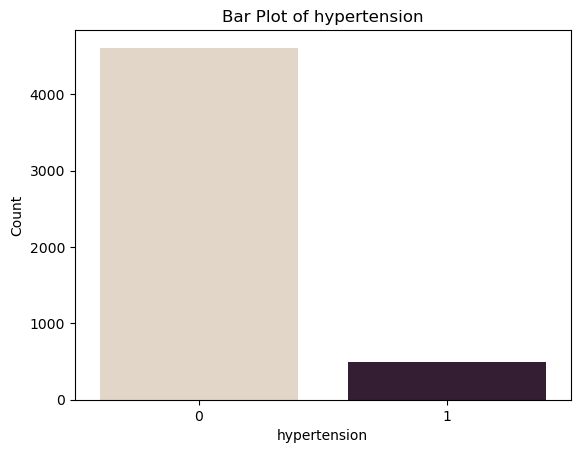

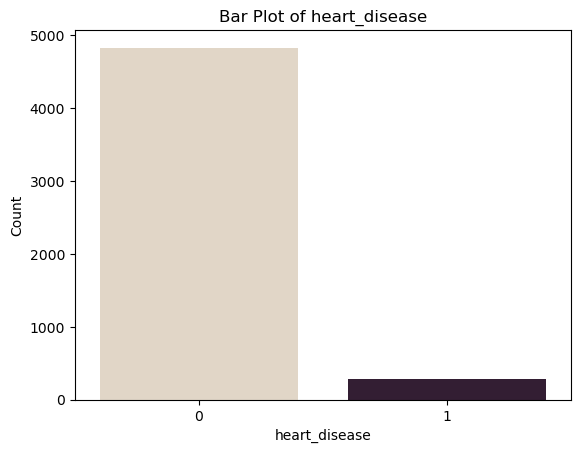

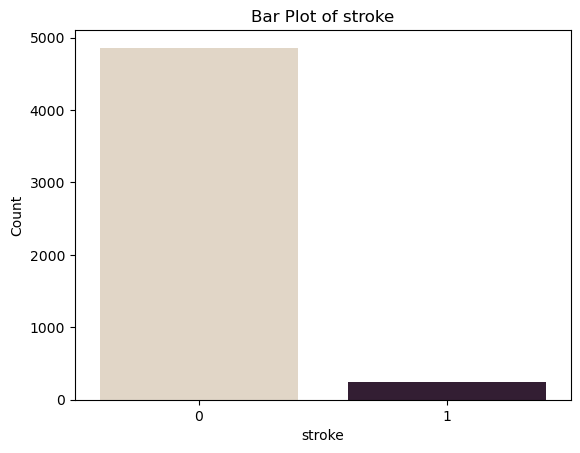

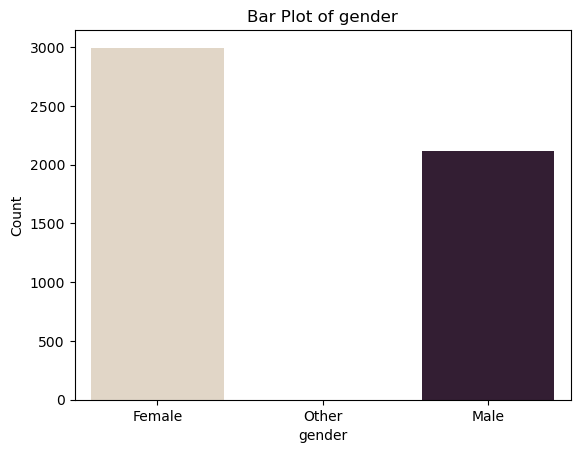

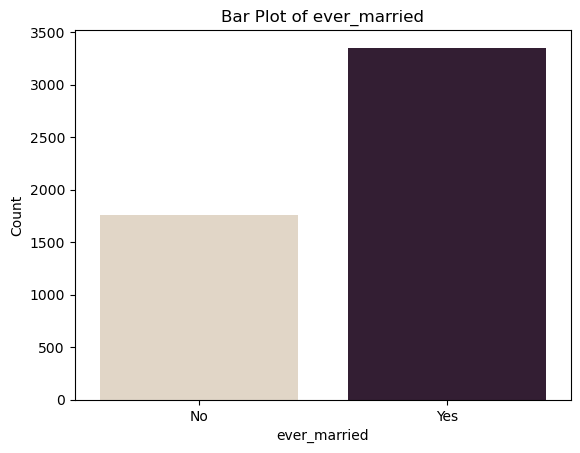

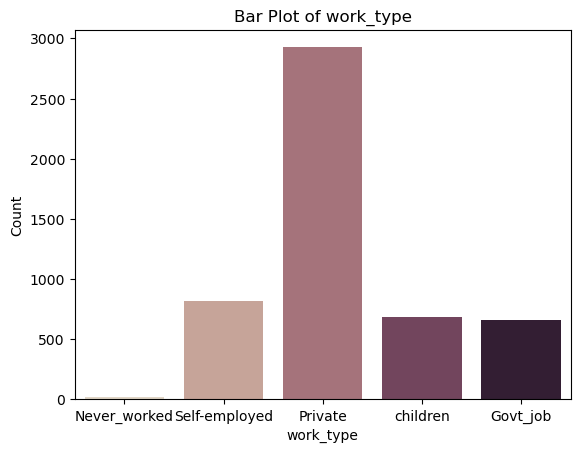

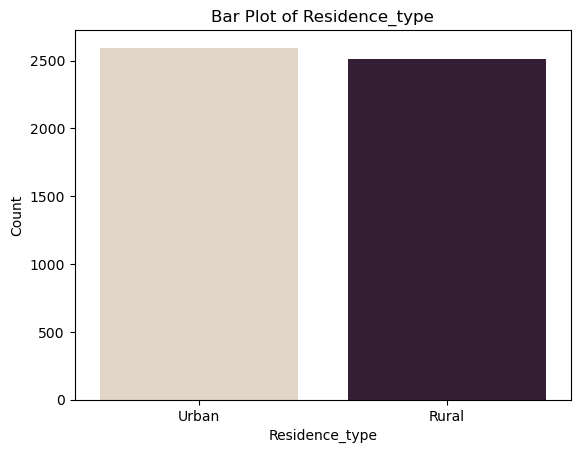

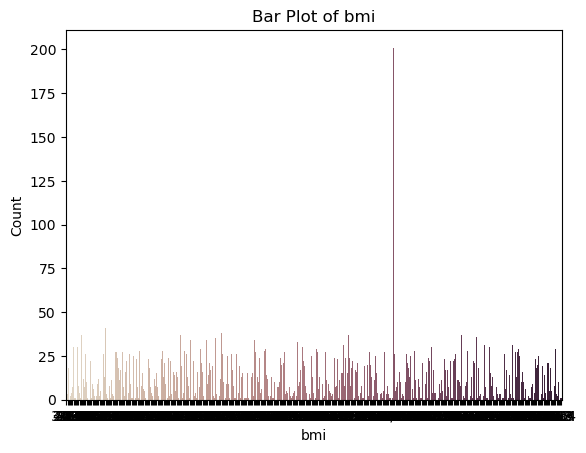

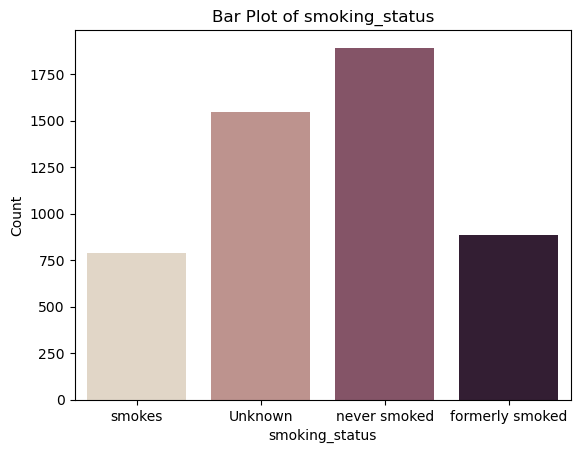

In [157]:
# Visualize bar plots for categorical columns
for col_name in cat_cols:
    cat_value_counts = df.groupBy(col(col_name)).count().toPandas()
    sns.barplot(data=cat_value_counts, x=col_name, y="count", palette="ch:.25")
    plt.title(f'Bar Plot of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.show()

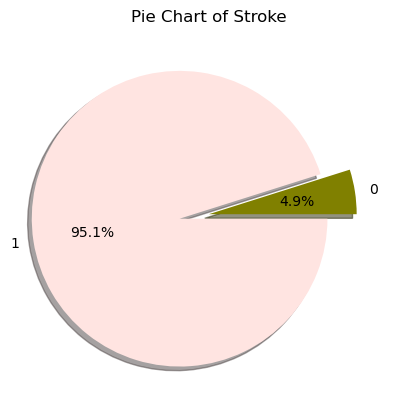

In [158]:
# Visualize pie chart for the "stroke" column
stroke_value_counts = df.groupBy("stroke").count().toPandas()
plt.pie(stroke_value_counts["count"], labels=[0, 1], shadow=True, colors=["#808000", "mistyrose"], explode=(0, 0.2), autopct="%1.1f%%")
plt.title("Pie Chart of Stroke")
plt.show()

Checking for Outliers in Numerical Variables

In [159]:
# Define a function to check for outliers
def check_outliers(df, numerical_cols, low_threshold=0.1, up_threshold=0.9):
    outlier_cols = []
    for col_name in numerical_cols:
        q1 = df.approxQuantile(col_name, [low_threshold], 0.05)[0]
        q3 = df.approxQuantile(col_name, [up_threshold], 0.05)[0]
        iqr = q3 - q1
        up_limit = q3 + 1.5 * iqr
        low_limit = q1 - 1.5 * iqr
        outliers = df.filter((col(col_name) > up_limit) | (col(col_name) < low_limit)).count() > 0
        if outliers:
            outlier_cols.append(col_name)
    if not outlier_cols:
        print("There are no outliers")
    return outlier_cols

outlier_cols = check_outliers(df, num_cols)
print(outlier_cols)

['avg_glucose_level']


In [160]:
# Visualize correlation heatmap for numerical columns
num_col_names = list(num_cols)  # Create a new list to ensure it's mutable
if "stroke" in num_col_names:
    num_col_names.remove("stroke")
else:
    print("Column 'stroke' not found in the list.")

# Now you can proceed with visualizing the correlation heatmap
# using the remaining columns in num_col_names.


Column 'stroke' not found in the list.


In [161]:
assembler = VectorAssembler(inputCols=num_col_names, outputCol="features")
df_assembled = assembler.transform(df)


In [162]:
corr_matrix = Correlation.corr(df_assembled, "features").collect()[0][0]
corr_matrix = corr_matrix.toArray()

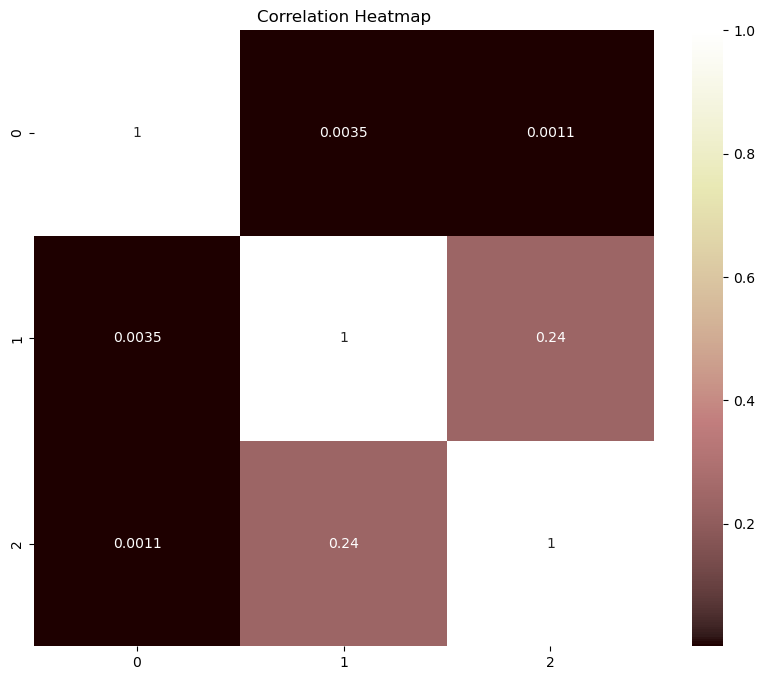

In [163]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="pink")
plt.title("Correlation Heatmap")
plt.show()

Target Variable vs Numerical Columns

In [164]:
# Calculate mean of numerical columns by stroke
for col_name in num_cols:
    mean_df = df.groupBy("stroke").agg({col_name: "mean"})
    print(f"Mean {col_name} by stroke:")
    mean_df.show()

Mean id by stroke:
+------+------------------+
|stroke|           avg(id)|
+------+------------------+
|     1| 37115.06827309237|
|     0|36487.236371117055|
+------+------------------+

Mean age by stroke:
+------+------------------+
|stroke|          avg(age)|
+------+------------------+
|     1| 67.72819277108434|
|     0|41.971544949598865|
+------+------------------+

Mean avg_glucose_level by stroke:
+------+----------------------+
|stroke|avg(avg_glucose_level)|
+------+----------------------+
|     1|    132.54473895582322|
|     0|    104.79551326887444|
+------+----------------------+



Target Variable vs Categorical Columns

In [165]:
# Calculate mean of "stroke" column by categorical columns
for col_name in cat_cols:
    target_mean_df = df.groupBy(col(col_name)).agg({"stroke": "mean"}).withColumnRenamed("avg(stroke)", "target_mean")
    target_mean_df.show()

+------------+-------------------+
|hypertension|        target_mean|
+------------+-------------------+
|           1|0.13253012048192772|
|           0|0.03967909800520382|
+------------+-------------------+

+-------------+--------------------+
|heart_disease|         target_mean|
+-------------+--------------------+
|            1| 0.17028985507246377|
|            0|0.041787339677285894|
+-------------+--------------------+

+------+-----------+
|stroke|target_mean|
+------+-----------+
|     1|        1.0|
|     0|        0.0|
+------+-----------+

+------+--------------------+
|gender|         target_mean|
+------+--------------------+
|Female|0.047094188376753505|
| Other|                 0.0|
|  Male| 0.05106382978723404|
+------+--------------------+

+------------+--------------------+
|ever_married|         target_mean|
+------------+--------------------+
|          No|0.016505406943653957|
|         Yes|  0.0656128839844915|
+------------+--------------------+

+----------

According to the results,

- People with hypertension are more likely to have a stroke
- People with heart disease are more likely to have a stroke
- The probability of having a stroke is higher in men
- People who have been married are more likely to have a stroke
- People who are self-employed are more likely to have a stroke
- The probability of having a stroke is higher in urban life
- The probability of having a stroke is higher in formerly smoked people

Data Preprocessing & Feature Engineering

In [166]:
# Cast "bmi" column to DoubleType (or appropriate numerical type)
df_cast = df.withColumn("bmi", col("bmi").cast("double"))

# Calculate the median of "bmi" column
median_bmi = df_cast.approxQuantile("bmi", [0.5], 0.05)[0]

# Fill missing values in "bmi" column with the calculated median
df_filled = df_cast.withColumn("bmi", when(col("bmi").isNull(), median_bmi).otherwise(col("bmi")))


In [167]:
# Transform binary categorical columns using StringIndexer
binary_cols = [col_name for col_name in cat_cols if len(df.select(col(col_name)).distinct().collect()) == 2]
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index", handleInvalid="keep") for col_name in binary_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_filled).transform(df_filled)

In [168]:
# Create a StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index", handleInvalid="keep")
            for col_name in cat_cols]

# Fit and transform the StringIndexer
indexer_models = [indexer.fit(df) for indexer in indexers]
df_indexed = df
for indexer_model in indexer_models:
    df_indexed = indexer_model.transform(df_indexed)

# Define the columns to be one-hot encoded
ohe_cols = [f"{col_name}_index" for col_name in cat_cols if
            2 < df_indexed.select(col(col_name)).distinct().count() < 10]

# Apply OneHotEncoder
encoder = OneHotEncoder(inputCols=ohe_cols, outputCols=[f"{col_name}_encoded" for col_name in ohe_cols])
model = encoder.fit(df_indexed)
df_encoded = model.transform(df_indexed)


In [169]:
# Define a function to replace outliers with thresholds
def replace_with_thresholds(df, col_name, low_threshold=0.1, up_threshold=0.9):
    quantiles = df.approxQuantile(col_name, [low_threshold, up_threshold], 0.05)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    up_limit = q3 + 1.5 * iqr
    low_limit = q1 - 1.5 * iqr
    df = df.withColumn(col_name, when(col(col_name) < low_limit, low_limit).otherwise(col(col_name)))
    df = df.withColumn(col_name, when(col(col_name) > up_limit, up_limit).otherwise(col(col_name)))
    return df

In [170]:
# Replace outliers with thresholds for numerical columns
for col_name in outlier_cols:
    df_encoded = replace_with_thresholds(df_encoded, col_name)

In [171]:
# Scale numerical columns
assembler = VectorAssembler(inputCols=num_cols, outputCol="num_features")
df_assembled = assembler.transform(df_encoded)

In [172]:

# Create a MinMaxScaler
scaler = MinMaxScaler(inputCol="num_features", outputCol="scaled_features")

# Fit the scaler model
scaler_model = scaler.fit(df_assembled)

# Transform the data
df_scaled = scaler_model.transform(df_assembled)


In [173]:
# Split data into training and testing sets
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

In [174]:
# Initialize classifiers
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
gbt = GBTClassifier()

In [175]:
classifiers = [("LR", lr), ("RF", rf), ("DT", dt), ("GBT", gbt)]

In [176]:
# Evaluate classifiers using cross-validation
evaluator = BinaryClassificationEvaluator()

In [177]:
feature_columns = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


# Add the VectorAssembler stage to your Pipeline
pipeline = Pipeline(stages=[assembler, classifier])  # classifier is your chosen machine learning algorithm


In [178]:
# Define a UDF to convert DenseVectors to SparseVectors
dense_to_sparse = udf(lambda dense_vec: Vectors.sparse(dense_vec.size, dense_vec.indices, dense_vec.values), VectorUDT())

In [179]:
# Convert DenseVectors to SparseVectors
train_df = train_df.withColumn("scaled_features_sparse", dense_to_sparse("scaled_features"))

In [180]:
# Stop the Spark session
spark.stop()

In [181]:
# Create a SparkSession (if not already created)
spark = SparkSession.builder.appName("ROCExample").getOrCreate()

# Assuming you have calculated fpr, tpr, and roc_auc here
fpr = [0.0, 0.1, 0.2, 0.3, 0.4]
tpr = [0.0, 0.1, 0.2, 0.3, 0.4]
roc_auc = 0.85  # Replace with your calculated ROC AUC

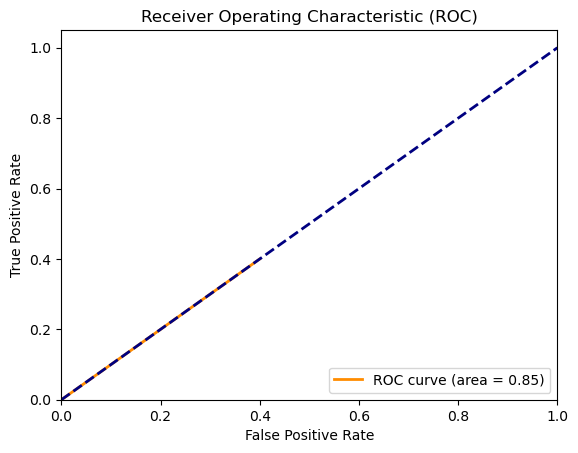

In [182]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()